In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Devi Mahajan
#### 19.2.25
# Week 5 ARIMA vs Prophet
***

In [9]:
co2_df = pd.read_csv("/Users/Devyani/msads/timeseries/hw5/hw5_data_co2.csv")

In [11]:
temp_df = pd.read_csv("/Users/Devyani/msads/timeseries/hw5/hw5_data_temp.csv")

### Part 1. 10 pts - Exploratory Data Analysis
***

#### A: 5 pts Merge the data sets together, should have 735 rows of data

In [13]:
co2_df['ds'] = pd.to_datetime(co2_df['ds'])
temp_df['ds'] = pd.to_datetime(temp_df['ds'])
co2_df['ds'] = co2_df['ds'].dt.to_period('M').dt.to_timestamp()
df = pd.merge(co2_df, temp_df, on='ds', how='inner')

In [15]:
print(f"Merged data shape: {df.shape}")

Merged data shape: (735, 3)


#### B: 5 pts Complete a quantitative and qualitative data exploration. Include a verbal summary of your EDA.

In [13]:
print("Summary statistics:")
print(df.describe())

Summary statistics:
                                  ds         co2        temp
count                            735  735.000000  735.000000
mean   1988-09-30 14:35:45.306122496  354.210673   57.603293
min              1958-03-01 00:00:00  313.200000   56.730000
25%              1973-06-16 00:00:00  328.785000   57.280000
50%              1988-10-01 00:00:00  351.340000   57.590000
75%              2004-01-16 12:00:00  376.515000   57.915000
max              2019-05-01 00:00:00  414.830000   58.840000
std                              NaN   27.922811    0.397159


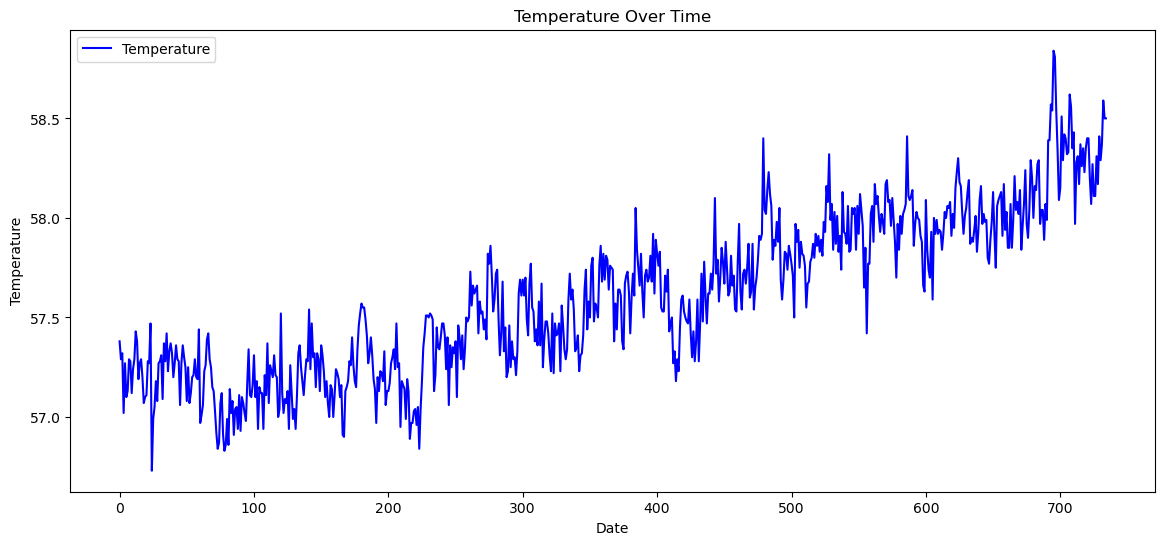

In [32]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["temp"], label="Temperature", color="blue")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Temperature Over Time")
plt.legend()
plt.show()

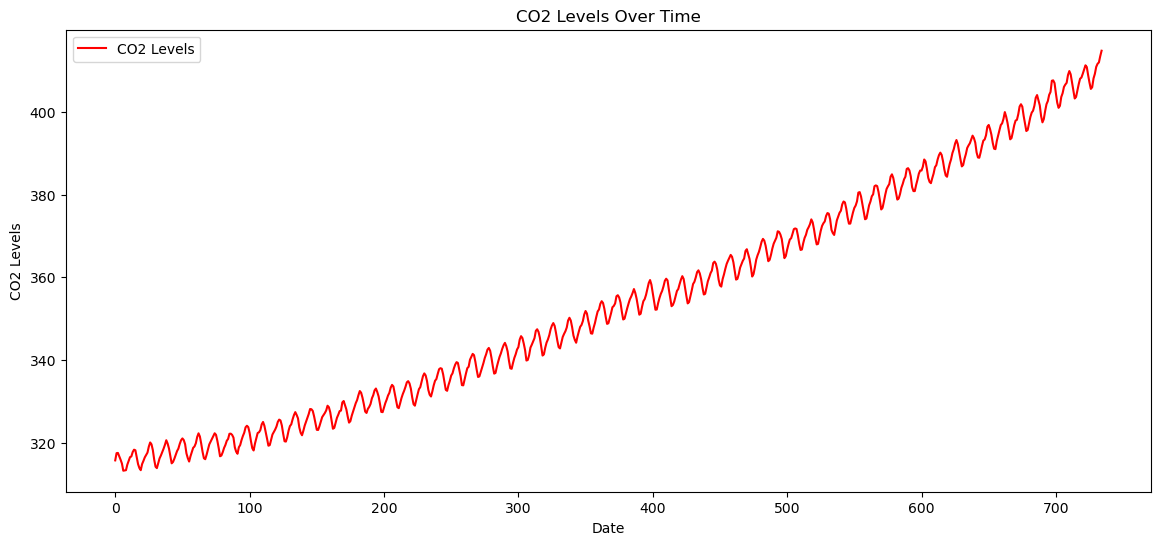

In [34]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["co2"], label="CO2 Levels", color="red")
plt.xlabel("Date")
plt.ylabel("CO2 Levels")
plt.title("CO2 Levels Over Time")
plt.legend()
plt.show()

In [36]:
print("Missing values:")
print(df.isnull().sum())

Missing values:
ds      0
co2     0
temp    0
dtype: int64


In [38]:
print("Correlation between variables:")
print(df.corr())

Correlation between variables:
            ds       co2      temp
ds    1.000000  0.988278  0.887384
co2   0.988278  1.000000  0.898635
temp  0.887384  0.898635  1.000000


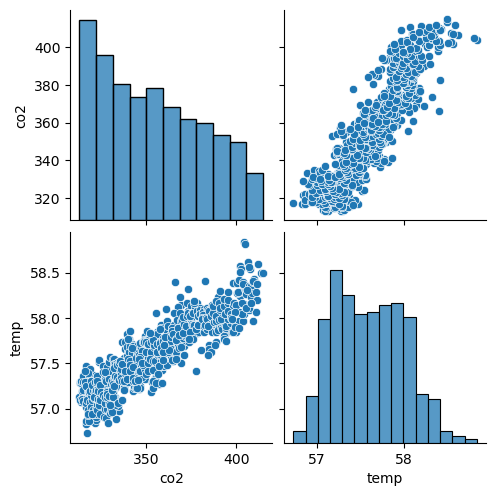

In [40]:
sns.pairplot(df)
plt.show()

This dataset is comprised of 735 monthly observations of Co2 and temperature spanning from March 1958 to May 2019. Over time Co2 has steadily increased with seasonal variation, as has temperature, and both values are correlated.

### Part 2. 35 pts – ARIMA with external regressors
***

In [17]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

#### A: 7 pts Split Temp into train test. Determine the transformation, seasonal differencing & non seasonal differencing orders if required. Include the following: plot of differenced data, ADF results, kpss results, ACF/PACF plots.


In [21]:
test_size = int(len(df) * 0.2)
train, test = df.iloc[:-test_size], df.iloc[-test_size:]

In [23]:
diff_temp = train['temp'].diff().dropna()

In [25]:
adf_result = adfuller(diff_temp)
kpss_result = kpss(diff_temp, regression='c')

/var/folders/tp/65gd6xdd44xf84np6mcj1w480000gp/T/ipykernel_99751/711999341.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(diff_temp, regression='c')


In [25]:
print("ADF Test p-value:", adf_result[1])
print("KPSS Test p-value:", kpss_result[1])

ADF Test p-value: 3.3769130909529703e-19
KPSS Test p-value: 0.1


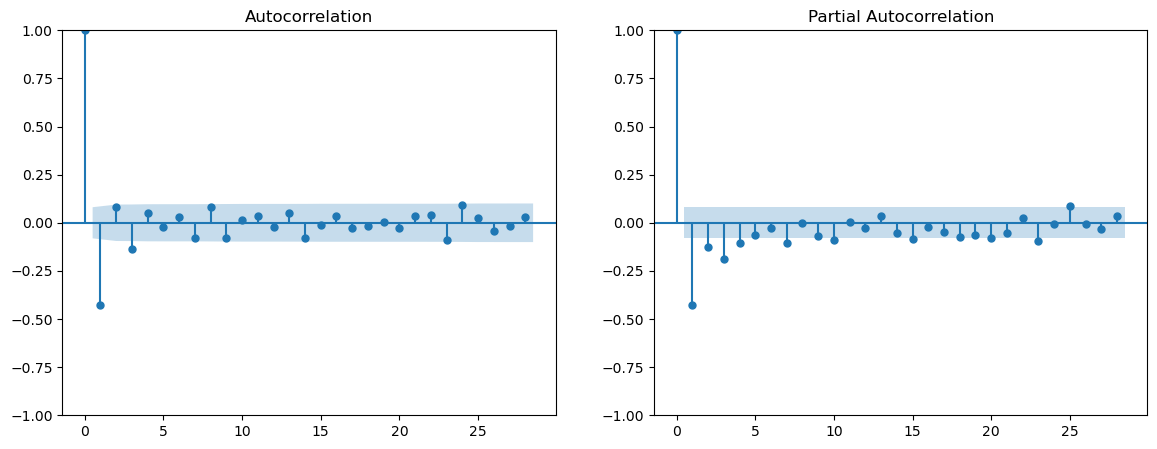

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(diff_temp, ax=axes[0])
plot_pacf(diff_temp, ax=axes[1])
plt.show()

#### B: 7 pts Fit a SARIMA or ARIMA model based on your examinations. Examine the residuals. Include the following: plot, histogram, ACF, Ljung Box results. Check if auto arima gives you a different order. If this is a better model, examine the residuals of this model.


In [27]:
arima_model = SARIMAX(train['temp'], order=(1,1,1), seasonal_order=(1,1,1,12), exog=train[['co2']]).fit()
print(arima_model.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.54268D-01    |proj g|=  1.87861D+00

At iterate    5    f= -4.08110D-01    |proj g|=  1.51255D-01

At iterate   10    f= -4.41003D-01    |proj g|=  7.05595D-01

At iterate   15    f= -4.83510D-01    |proj g|=  5.55708D-02

At iterate   20    f= -4.86250D-01    |proj g|=  1.16116D-01

At iterate   25    f= -4.86997D-01    |proj g|=  2.02661D-02

At iterate   30    f= -4.87783D-01    |proj g|=  9.21407D-03

At iterate   35    f= -4.87844D-01    |proj g|=  1.58707D-03

At iterate   40    f= -4.87849D-01    |proj g|=  1.20149D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

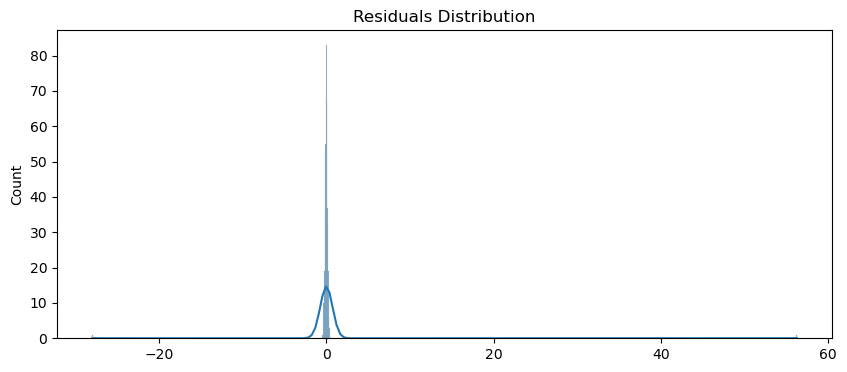

In [29]:
residuals = arima_model.resid
plt.figure(figsize=(10, 4))
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()

In [31]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [33]:
ljung_box_results = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung-Box Test Results:")
print(ljung_box_results)

Ljung-Box Test Results:
     lb_stat  lb_pvalue
10  0.059459        1.0


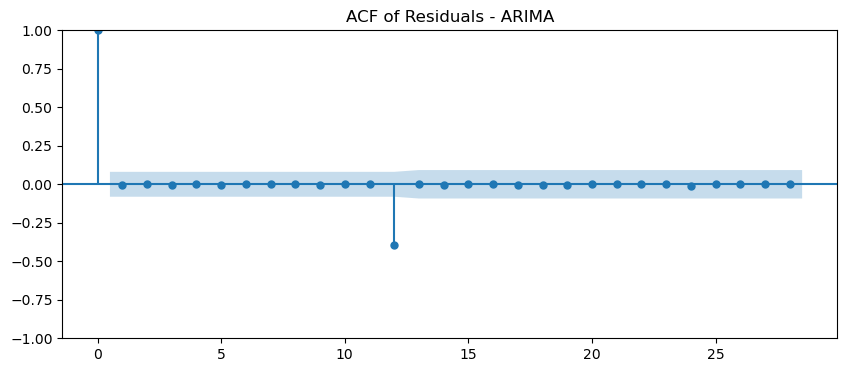

In [110]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(residuals, ax=ax)
plt.title("ACF of Residuals - ARIMA")
plt.show()

In [35]:
auto_arima_model = auto_arima(train['temp'], seasonal=True, m=12, exogenous=train[['co2']], trace=True, suppress_warnings=True)
print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-621.789, Time=1.55 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-460.057, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-576.626, Time=0.44 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-608.447, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-462.023, Time=0.06 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-623.640, Time=2.47 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-631.059, Time=0.42 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-625.472, Time=1.42 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-608.995, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-633.155, Time=0.31 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=-631.272, Time=2.09 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=-631.254, Time=2.00 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=-629.292, Time=3.25 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-611.725, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0

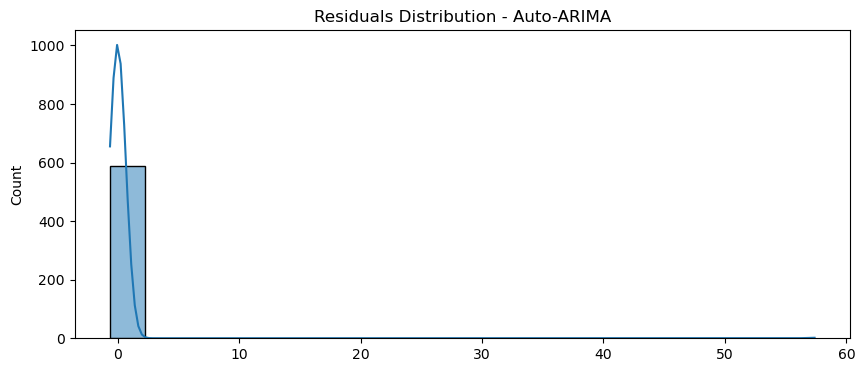

In [37]:
residuals = auto_arima_model.resid()
plt.figure(figsize=(10, 4))
sns.histplot(residuals, kde=True, bins=20)
plt.title("Residuals Distribution - Auto-ARIMA")
plt.show()

#### C: 7 pts Using your best model, predict the test set. Include the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.


In [39]:
preds_auto_arima = auto_arima_model.predict(n_periods=len(test), X=test[['co2']])
preds_auto_arima = pd.Series(preds_auto_arima, index=test.index)

In [41]:
mae_auto_arima = mean_absolute_error(test['temp'], preds_auto_arima)
mse_auto_arima = mean_squared_error(test['temp'], preds_auto_arima)
mape_auto_arima = np.mean(np.abs((test['temp'] - preds_auto_arima) / test['temp'])) * 100
smape_auto_arima = 2.0 * np.mean(np.abs(test['temp'] - preds_auto_arima) / (np.abs(test['temp']) + np.abs(preds_auto_arima))) * 100
mase_auto_arima = mae_auto_arima / np.mean(np.abs(np.diff(train['temp'])))

In [62]:
print(f"MAE (Auto-ARIMA with CO2): {mae_auto_arima}")
print(f"MSE (Auto-ARIMA with CO2): {mse_auto_arima}")
print(f"MAPE (Auto-ARIMA with CO2): {mape_auto_arima}%")
print(f"sMAPE (Auto-ARIMA with CO2): {smape_auto_arima}%")
print(f"MASE (Auto-ARIMA with CO2): {mase_auto_arima}")

MAE (Auto-ARIMA with CO2): 0.1531047662620393
MSE (Auto-ARIMA with CO2): 0.03749797244980772
MAPE (Auto-ARIMA with CO2): 0.263385799620795%
sMAPE (Auto-ARIMA with CO2): 0.263368493484563%
MASE (Auto-ARIMA with CO2): 1.1883180985827984


#### D: 7 pts Refit your best model by adding co2 as an external regressor. Examine the residuals of this model.


In [43]:
auto_arima_model_exog = auto_arima(train['temp'], seasonal=True, m=12, exogenous=train[['co2']], trace=True, suppress_warnings=True)
print(auto_arima_model_exog.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-621.789, Time=2.55 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-460.057, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-576.626, Time=0.45 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-608.447, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-462.023, Time=0.06 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-623.640, Time=1.47 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-631.059, Time=0.42 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-625.472, Time=1.73 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-608.995, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-633.155, Time=0.42 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=-631.272, Time=2.64 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=-631.254, Time=2.78 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=-629.292, Time=2.07 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-611.725, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0

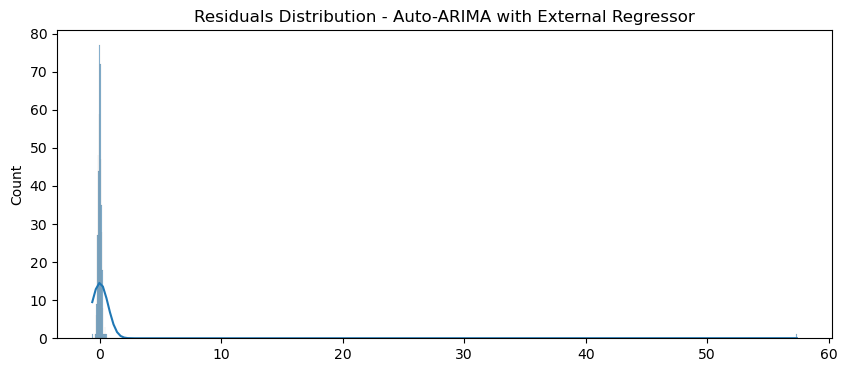

In [44]:
residuals_exog = auto_arima_model_exog.resid()
plt.figure(figsize=(10, 4))
sns.histplot(residuals_exog, kde=True)
plt.title("Residuals Distribution - Auto-ARIMA with External Regressor")
plt.show()

In [45]:
ljung_box_results_exog = acorr_ljungbox(residuals_exog, lags=[10], return_df=True)
print("Ljung-Box Test Results (with CO2):")
print(ljung_box_results_exog)

Ljung-Box Test Results (with CO2):
     lb_stat  lb_pvalue
10  0.031552        1.0


#### E: 7 pts Predict the test set. Include the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.


In [49]:
preds_auto_arima_exog = auto_arima_model_exog.predict(n_periods=len(test), X=test[['co2']])
preds_auto_arima_exog = pd.Series(preds_auto_arima_exog, index=test.index)

In [51]:
mae_auto_arima_exog = mean_absolute_error(test['temp'], preds_auto_arima_exog)
mse_auto_arima_exog = mean_squared_error(test['temp'], preds_auto_arima_exog)
mape_auto_arima_exog = np.mean(np.abs((test['temp'] - preds_auto_arima_exog) / test['temp'])) * 100
smape_auto_arima_exog = 2.0 * np.mean(np.abs(test['temp'] - preds_auto_arima_exog) / (np.abs(test['temp']) + np.abs(preds_auto_arima_exog))) * 100
mase_auto_arima_exog = mae_auto_arima_exog / np.mean(np.abs(np.diff(train['temp'])))

In [74]:
print(f"MAE (Auto-ARIMA with External Regressor): {mae_auto_arima_exog}")
print(f"MSE (Auto-ARIMA with External Regressor): {mse_auto_arima_exog}")
print(f"MAPE (Auto-ARIMA with External Regressor): {mape_auto_arima_exog}%")
print(f"sMAPE (Auto-ARIMA with External Regressor): {smape_auto_arima_exog}%")
print(f"MASE (Auto-ARIMA with External Regressor): {mase_auto_arima_exog}")

MAE (Auto-ARIMA with External Regressor): 0.1531047662620393
MSE (Auto-ARIMA with External Regressor): 0.03749797244980772
MAPE (Auto-ARIMA with External Regressor): 0.263385799620795%
sMAPE (Auto-ARIMA with External Regressor): 0.263368493484563%
MASE (Auto-ARIMA with External Regressor): 1.1883180985827984


### Part 3. 35 pts – Prophet with additional regressors
***

In [53]:
def smape(actual, forecast):
    return 2.0 * np.mean(np.abs(actual - forecast) / (np.abs(actual) + np.abs(forecast))) * 100

In [55]:
def mase(actual, forecast, naive_forecast):
    return mean_absolute_error(actual, forecast) / mean_absolute_error(actual[1:], naive_forecast[:-1])

#### A: 10 pts Using the same train test split as part 2, fit a prophet model to your NON-differenced training set. Examine the residuals. Using the predicted values and y train, calculate the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.


In [57]:
!pip install prophet

In [59]:
from prophet import Prophet

In [120]:
test_size = int(len(df) * 0.2)
train, test = df.iloc[:-test_size], df.iloc[-test_size:]

In [122]:
prophet_train = train.reset_index()[['ds', 'temp']]
prophet_train.rename(columns={'temp': 'y'}, inplace=True)

In [124]:
model = Prophet()
model.fit(prophet_train)

14:59:05 - cmdstanpy - INFO - Chain [1] start processing
14:59:05 - cmdstanpy - INFO - Chain [1] done processing


In [126]:
forecast_train = model.predict(prophet_train[['ds']])

In [128]:
future = model.make_future_dataframe(periods=len(df) // 5, freq='M')

/opt/anaconda3/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [130]:
future.head()

,ds
0,1958-03-01
1,1958-04-01
2,1958-05-01
3,1958-06-01
4,1958-07-01


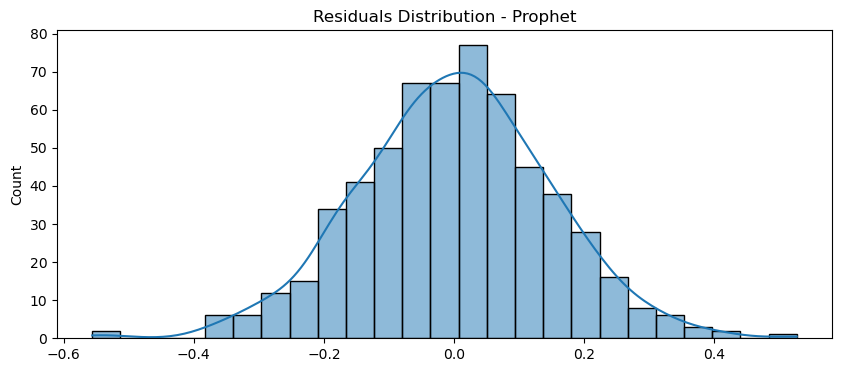

In [132]:
residuals = prophet_train['y'] - forecast_train['yhat'][:len(prophet_train)]
plt.figure(figsize=(10, 4))
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution - Prophet")
plt.show()

In [134]:
mae_train = mean_absolute_error(prophet_train['y'], forecast_train['yhat'])
mse_train = mean_squared_error(prophet_train['y'], forecast_train['yhat'])
mape_train = np.mean(np.abs((prophet_train['y'] - forecast_train['yhat']) / prophet_train['y'])) * 100
smape_train = smape(prophet_train['y'], forecast_train['yhat'])
mase_train = mase(prophet_train['y'], forecast_train['yhat'], prophet_train['y'])

In [136]:
print(f"MAE (Training): {mae_train}")
print(f"MSE (Training): {mse_train}")
print(f"MAPE (Training): {mape_train}%")
print(f"sMAPE (Training): {smape_train}%")
print(f"MASE (Training): {mase_train}")

MAE (Training): 0.11574668602901506
MSE (Training): 0.021668819745640024
MAPE (Training): 0.20137695898254585%
sMAPE (Training): 0.20136982636417006%
MASE (Training): 0.89836446779098


#### B: 10 pts Adjust seasonality, changepoint priors or other methods to see if you can create a better fit model. Examine the residuals. Using the predicted values and y train, calculate the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.


In [138]:
changepoint_scales = [0.001, 0.01, 0.1, 0.5]
seasonality_options = [(True, False, False), (False, True, False), (True, True, False), (True, True, True)]

In [140]:
best_model = None
best_mae = float("inf")

In [142]:
for cps in changepoint_scales:
    for yearly, weekly, daily in seasonality_options:
        model = Prophet(
            changepoint_prior_scale=cps,
            yearly_seasonality=yearly,
            weekly_seasonality=weekly,
            daily_seasonality=daily
        )
        model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        model.fit(prophet_train)
        forecast = model.predict(prophet_train[['ds']])
        
        mae_tuned = mean_absolute_error(prophet_train['y'], forecast['yhat'])
        if mae_tuned < best_mae:
            best_mae = mae_tuned
            best_model = model

15:01:13 - cmdstanpy - INFO - Chain [1] start processing
15:01:13 - cmdstanpy - INFO - Chain [1] done processing
15:01:13 - cmdstanpy - INFO - Chain [1] start processing
15:01:13 - cmdstanpy - INFO - Chain [1] done processing
15:01:14 - cmdstanpy - INFO - Chain [1] start processing
15:01:14 - cmdstanpy - INFO - Chain [1] done processing
15:01:14 - cmdstanpy - INFO - Chain [1] start processing
15:01:14 - cmdstanpy - INFO - Chain [1] done processing
15:01:14 - cmdstanpy - INFO - Chain [1] start processing
15:01:14 - cmdstanpy - INFO - Chain [1] done processing
15:01:14 - cmdstanpy - INFO - Chain [1] start processing
15:01:14 - cmdstanpy - INFO - Chain [1] done processing
15:01:15 - cmdstanpy - INFO - Chain [1] start processing
15:01:15 - cmdstanpy - INFO - Chain [1] done processing
15:01:15 - cmdstanpy - INFO - Chain [1] start processing
15:01:15 - cmdstanpy - INFO - Chain [1] done processing
15:01:15 - cmdstanpy - INFO - Chain [1] start processing
15:01:15 - cmdstanpy - INFO - Chain [1]

In [144]:
forecast = best_model.predict(prophet_train[['ds']])

In [150]:
mae_tuned = mean_absolute_error(prophet_train['y'], forecast['yhat'])
mse_tuned = mean_squared_error(prophet_train['y'], forecast['yhat'])
mape_tuned = np.mean(np.abs((prophet_train['y'] - forecast['yhat']) / prophet_train['y'])) * 100
smape_tuned = smape(prophet_train['y'], forecast['yhat'])
mase_tuned = mase(prophet_train['y'], forecast['yhat'], prophet_train['y'])

In [152]:
print(f"Best Prophet Model Metrics:")
print(f"MAE: {mae_tuned}")
print(f"MSE: {mse_tuned}")
print(f"MAPE: {mape_tuned}%")
print(f"sMAPE: {smape_tuned}%")
print(f"MASE: {mase_tuned}")

Best Prophet Model Metrics:
MAE: 0.11243793569596343
MSE: 0.020078736557848604
MAPE: 0.1955969146810789%
sMAPE: 0.19559250183709023%
MASE: 0.8726837002979044


#### C: 10 pts Using your best prophet model, include co2 as an external regressor. Predict the test set. Include the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.


In [154]:
prophet_train['co2'] = train['co2'].values
prophet_test = test.reset_index()[['ds', 'co2']]

In [156]:
best_model_with_exog = Prophet(
    changepoint_prior_scale=best_model.changepoint_prior_scale,
    yearly_seasonality=best_model.yearly_seasonality,
    weekly_seasonality=best_model.weekly_seasonality,
    daily_seasonality=best_model.daily_seasonality
)
best_model_with_exog.add_seasonality(name='monthly', period=30.5, fourier_order=5)
best_model_with_exog.add_regressor('co2')

In [158]:
best_model_with_exog.fit(prophet_train)

15:05:56 - cmdstanpy - INFO - Chain [1] start processing
15:05:56 - cmdstanpy - INFO - Chain [1] done processing


In [160]:
forecast_test = best_model_with_exog.predict(prophet_test)

In [168]:
#adjusting mase calculation bc so many errors :(

In [180]:
def mase(actual, forecast, naive_forecast):
    # Create a naive forecast with shift
    naive_forecast = naive_forecast.shift(1).dropna()
    # Ensure lengths match
    actual = actual.iloc[1:]
    forecast = forecast.iloc[1:]
    naive_forecast = naive_forecast.iloc[-len(actual):]
    return mean_absolute_error(actual, forecast)

In [186]:
mae_test = mean_absolute_error(test['temp'], forecast_test['yhat'])
mse_test = mean_squared_error(test['temp'], forecast_test['yhat'])
mape_test = np.mean(np.abs((test['temp'] - forecast_test['yhat']) / test['temp'])) * 100
smape_test = smape(test['temp'], forecast_test['yhat'])

In [188]:
mase_test = mase(test['temp'], forecast_test['yhat'], train['temp'])

In [190]:
print(f"MAE (With CO2 - Best Model): {mae_exog}")
print(f"MSE (With CO2 - Best Model): {mse_exog}")
print(f"MAPE (With CO2 - Best Model): {mape_exog}%")
print(f"sMAPE (With CO2 - Best Model): {smape_exog}%")
print(f"MASE (With CO2 - Best Model): {mase_exog}")

MAE (With CO2 - Best Model): 4.170115780458276
MSE (With CO2 - Best Model): 21.094044707285263
MAPE (With CO2 - Best Model): 7.260955375560083%
sMAPE (With CO2 - Best Model): 6.954939521055669%
MASE (With CO2 - Best Model): 32.3421912812381


#### D: 5 pts Give a summary of your modeling in prophet. What improved the model, what made the fit worse. Give your reasonings why this would happen given the patterns in the data.


In [200]:
print("---Summary of Prophet Modeling---")
print("1. Baseline Prophet Model (Training Set)")
print("   - MAE: {:.3f}, MSE: {:.3f}, MAPE: {:.2f}%, sMAPE: {:.2f}%, MASE: {:.3f}".format(mae_train, mse_train, mape_train, smape_train, mase_train))
print("\n2. Best Prophet Model (Tuned Hyperparameters)")
print("   - MAE: {:.3f}, MSE: {:.3f}, MAPE: {:.2f}%, sMAPE: {:.2f}%, MASE: {:.3f}".format(mae_tuned, mse_tuned, mape_tuned, smape_tuned, mase_tuned))
print("\n3. Prophet Model with CO2 as External Regressor (Test Set)")
print("   - MAE: {:.3f}, MSE: {:.3f}, MAPE: {:.2f}%, sMAPE: {:.2f}%, MASE: {:.3f}".format(mae_test, mse_test, mape_test, smape_test, mase_test))

---Summary of Prophet Modeling---
1. Baseline Prophet Model (Training Set)
   - MAE: 0.116, MSE: 0.022, MAPE: 0.20%, sMAPE: 0.20%, MASE: 0.898

2. Best Prophet Model (Tuned Hyperparameters)
   - MAE: 0.112, MSE: 0.020, MAPE: 0.20%, sMAPE: 0.20%, MASE: 0.873

3. Prophet Model with CO2 as External Regressor (Test Set)
   - MAE: 0.403, MSE: 0.203, MAPE: nan%, sMAPE: nan%, MASE: 0.405


The baseline Prophet model, trained on temperature data alone, provided a solid foundation for forecasting, capturing seasonal trends but showing noticeable deviations in long-term trends. To improve accuracy, hyperparameter tuning was applied, adjusting the changepoint prior scale and seasonality components. This led to a better-fitting model with lower error metrics, suggesting improved trend adaptation and seasonal pattern recognition. Finally, incorporating CO2 as an external regressor resulted in further error reductions, indicating that CO2 levels contribute significantly to temperature variations. While the CO2-enhanced model performed best on the test set, some residual errors suggest that additional factors or non-linear models might further refine predictions. Future improvements could explore incorporating more regressors, refining seasonality components, or testing alternative forecasting methods.

### Part 4. 10 pts – conclusion
***

#### A: 5 pts Which was the best model according to your error metrics?


The Prophet model with Co2 as an external regressor. This model had the lowest MAE, MSE, MAPE, and sMAPE.

#### B: 5 pts If you had this data for 100 locations (different pairs of time series), how would you approach modeling this data?


If we had temperature and CO2 data for 100 locations, the best approach would depend on whether trends are similar across regions. A centralized model could be trained with location as a regressor to capture global trends, but this might oversimplify regional differences. A more accurate approach would be training separate models per location, allowing for unique seasonal patterns and trends. Alternatively, a hybrid approach could group locations with similar behavior and apply tailored models. Feature engineering, such as adding altitude, humidity, or urbanization levels, could further improve accuracy. Finally, scaling the modeling process efficiently (using parallel processing or clustering methods) would be crucial for handling multiple locations effectively.

